In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import quandl

ModuleNotFoundError: No module named 'quandl'

In [2]:
def getPortfolio(stocks=['AAPL','AMZN','GOOGL','FB','AAL','AMGN']):
    # An example of stocks you can pick
    # You may find the symbols at:
    # https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_Component_Stocks
    # Apple, Amazon, Google, Facebook, American Airlines, Amgen Inc. 
    # ['AAPL','AMZN','GOOGL','FB','AAL','AMGN']
    
    # You need an API key to use the quandl API
    # the key below is mine, use wisely! (I can see your requests O_O)
    # We may ran out of API requests so you might
    # have to create a free account at: https://www.quandl.com/
    # you can find your key at: https://www.quandl.com/account/profile
    quandl.ApiConfig.api_key = 'dPrMfibAoaMUE_TQuhgk'

    # Get stock closing time values from 2009 to 2019
    data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                            qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                            date = { 'gte': '2009-1-1', 'lte': '2019-1-1' }, paginate=True)
    data.head()
    df = data.set_index('date')
    stock_table = df.pivot(columns='ticker')
    # By specifying col[1] in below list comprehension
    # You can select the stock names under multi-level column
    stock_table.columns = [col[1] for col in stock_table.columns]
    stock_table.head()
    return stock_table

In [4]:
import numpy as np

def portfolioReader(filename):
    #######################
    # Function to Skip Comments
    #######################
    def skipComments(idx, content):
        while idx < len(content) and content[idx].startswith('#'):
            idx += 1
        return idx

    #######################
    # Read File Content
    #######################
    with open(filename, 'r') as f:
        read_data = f.read().splitlines()  # Using splitlines() to avoid trailing empty strings

    idx = 0
    idx = skipComments(idx, read_data)

    # Read the number of assets
    N = int(read_data[idx].strip())
    idx += 1

    # Define arrays
    ret = np.zeros(N)
    sdv = np.zeros(N)
    covariance_mat = np.zeros((N, N))

    idx = skipComments(idx, read_data)

    # Populate return and standard deviation
    for ii in range(N):
        ret[ii], sdv[ii] = map(float, read_data[idx].strip().split())  # Assuming values are space-separated
        idx += 1

    idx = skipComments(idx, read_data)

    # Populate covariance matrix
    while idx < len(read_data) and not read_data[idx].startswith('#'):
        II, JJ, VAL = read_data[idx].strip().split()
        II, JJ = int(II), int(JJ)
        covariance_mat[II][JJ] = float(VAL)
        covariance_mat[JJ][II] = float(VAL)  # Assuming symmetry
        idx += 1

    return N, ret, sdv, covariance_mat


In [7]:
import numpy as np

def portfolioWriter(filename, table, market='S&P 500'):
    with open(filename, 'w') as f:
        f.write('#######################\n')
        f.write('# Market: ' + market + '\n')
        f.write('# Dates: ' + str(table.index[0]) + ' ' + str(table.index[-1]) + '\n')
        f.write('# Stocks: ' + np.array2string(table.columns) + '\n')
        f.write('#######################\n')
        f.write(' ' + str(len(table.columns)) + '\n')
        f.write('#######################\n')

        # Compute mean returns
        returns = table.pct_change().mean().values  # Assuming table contains stock prices

        # Compute standard deviations
        stds = table.pct_change().std().values

        for i in range(len(returns)):
            f.write(f' {returns[i]} {stds[i]}\n')

        f.write('#######################\n')

        # Compute correlation matrix
        corrMat = table.pct_change().corr().values  # Compute correlation matrix

        for (ii, jj), x in np.ndenumerate(corrMat):
            f.write(f' {ii + 1} {jj + 1} {x}\n')

        f.write('#######################\n')


In [8]:
def plotPrices(stock_table,fontsize=12,figsize=(14, 7)):
    # If you have issues with '%matplotlib inline' and '%config..'
    # you can just save the image with plt.savefig('plotPrices.png')
    plt.style.use('fivethirtyeight')
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.figure(figsize=figsize)
    for c in stock_table.columns.values:
        plt.plot(stock_table.index, stock_table[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=fontsize)
    plt.ylabel('price in $')

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plotReturns(stock_table, fontsize=12, figsize=(10, 5)):
    # Calculate daily percentage returns
    returns = stock_table.pct_change().dropna()  # Compute daily returns, drop NaN from the first row

    plt.figure(figsize=figsize)
    
    for c in returns.columns:
        plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)  # Plot each stock's returns
    
    plt.legend(loc='lower right', fontsize=fontsize)
    plt.ylabel('Daily Returns')
    plt.xlabel('Date')
    plt.title('Stock Returns Over Time', fontsize=fontsize + 2)
    plt.grid(True)
    plt.show()


In [168]:
#########################################################################
# Reading Writing and Visuaizing the portfolio!!!
#########################################################################

In [12]:
import pandas as pd  # Import pandas

# Corrected date parser function
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

# Read the CSV file with correct date parsing
stock_table = pd.read_csv('stock_table.csv', index_col='date', date_parser=dateparse)

# Convert index to datetime (optional, but ensures correctness)
stock_table.index = pd.to_datetime(stock_table.index)

print(stock_table.head())  # Check if data loads correctly


                  AAL       AAPL       AMGN   AMZN  FB       GOOGL
date                                                              
2009-01-02  21.800090  11.662640  51.611909  54.36 NaN  161.157478
2009-01-05  21.644190  12.154848  52.189360  54.06 NaN  164.532897
2009-01-06  23.540979  11.954366  51.043207  57.36 NaN  167.547202
2009-01-07  23.592946  11.696053  50.920717  56.20 NaN  161.503546
2009-01-08  24.866134  11.913242  51.848139  57.16 NaN  163.098469


C:\Users\krish\AppData\Local\Temp\ipykernel_20452\977869999.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_table = pd.read_csv('stock_table.csv', index_col='date', date_parser=dateparse)


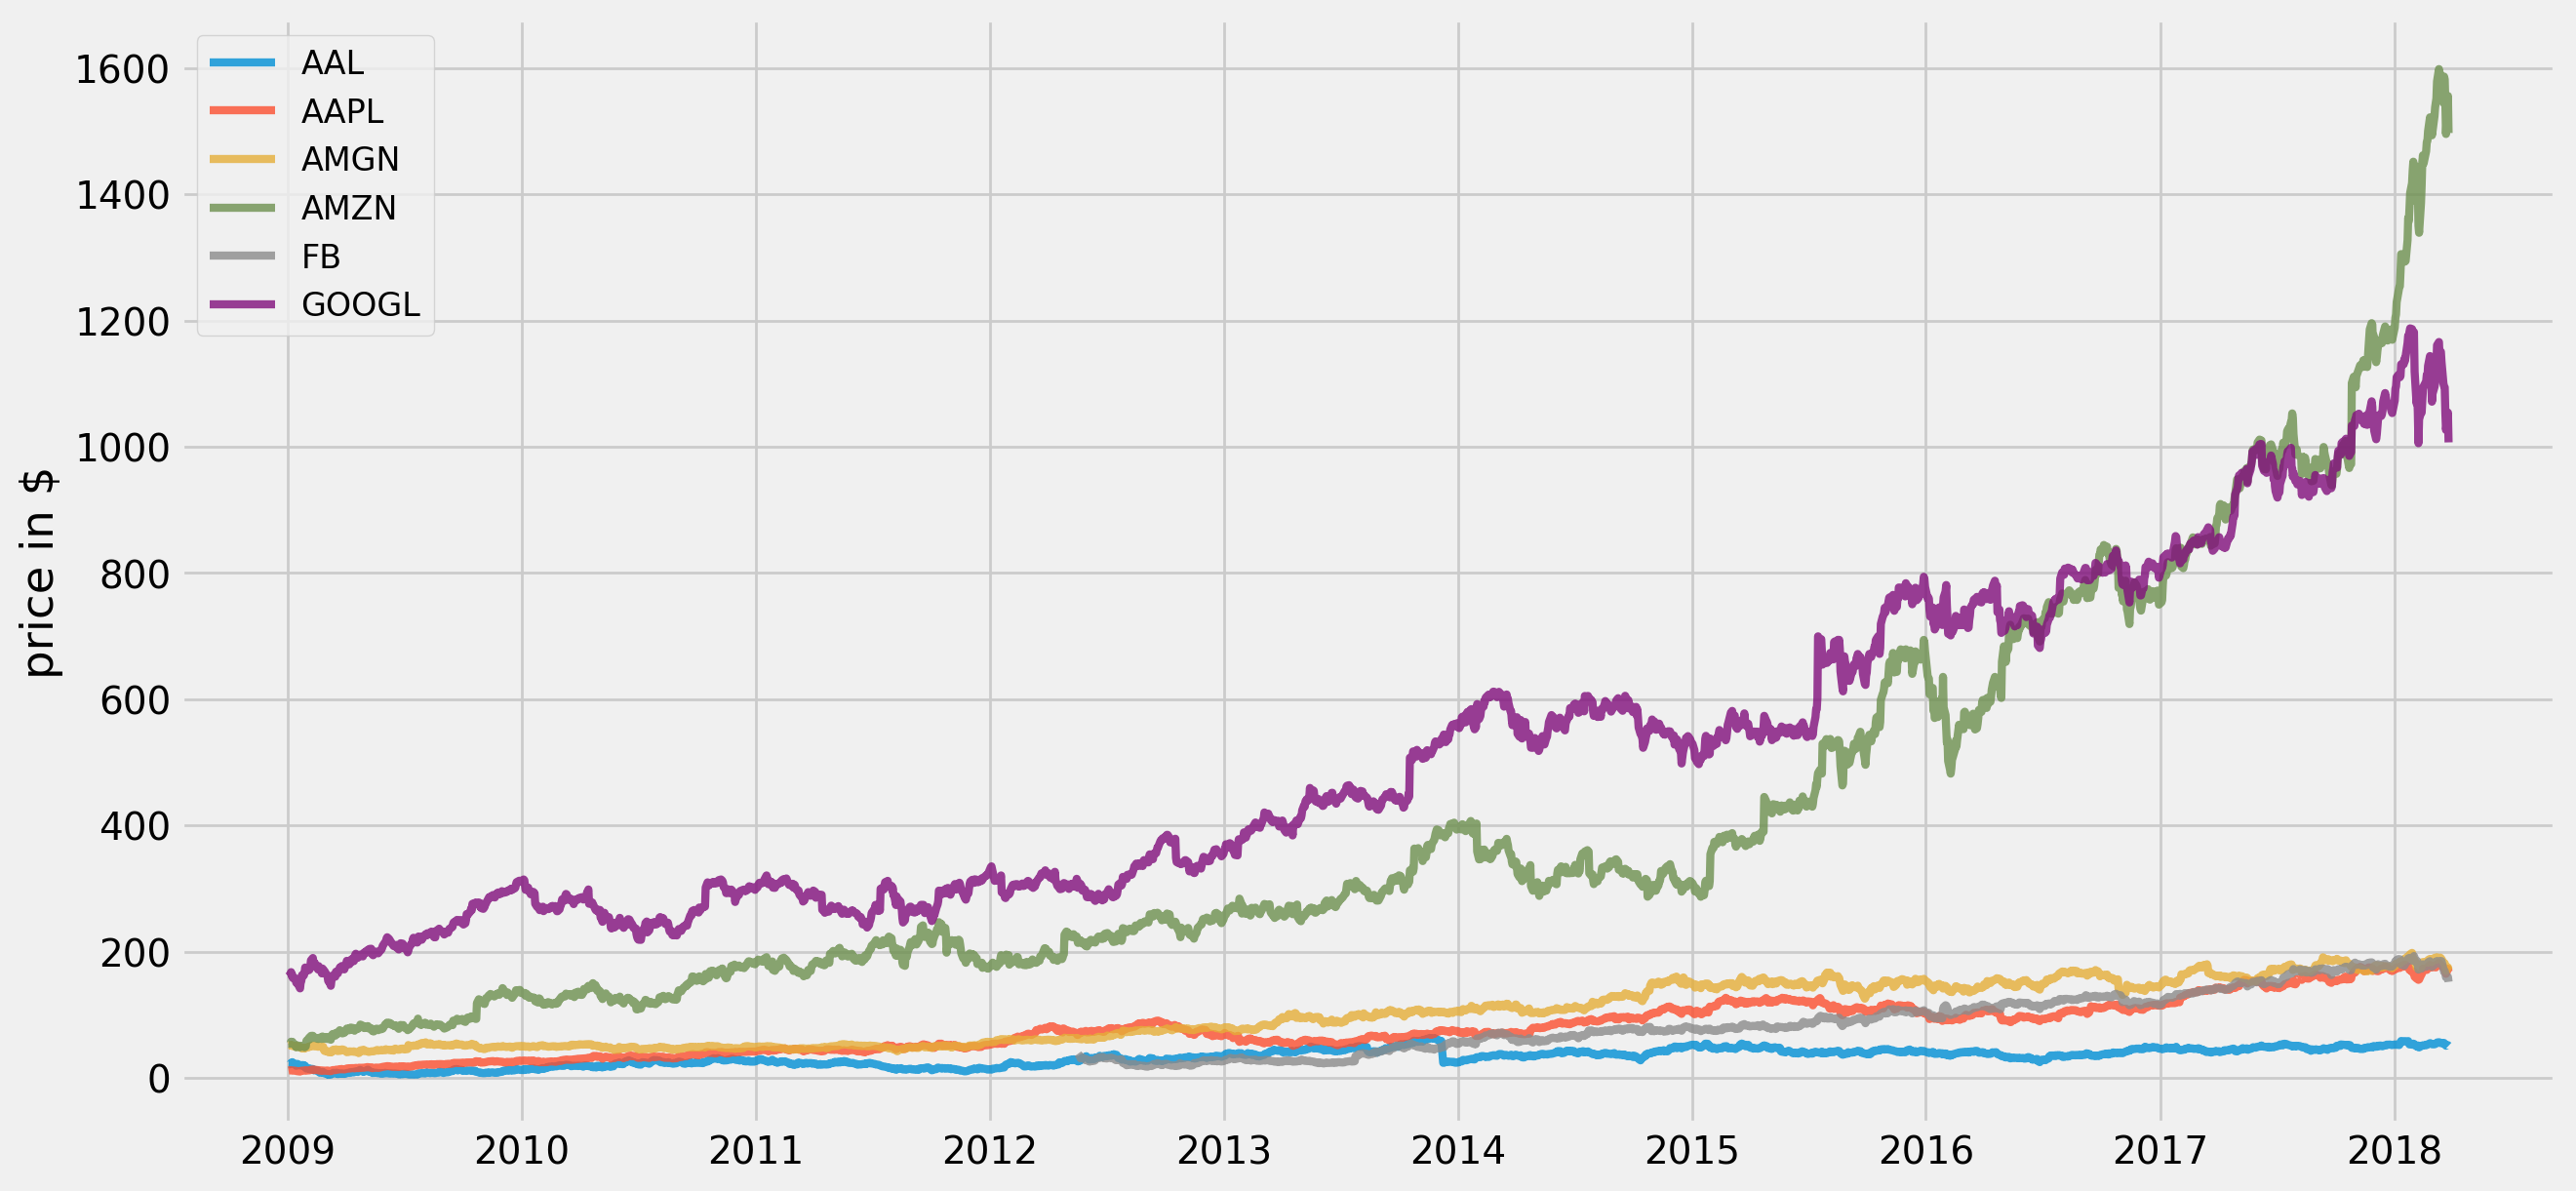

In [13]:
plotPrices(stock_table)

C:\Users\krish\AppData\Local\Temp\ipykernel_20452\1870696478.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = stock_table.pct_change().dropna()  # Compute daily returns, drop NaN from the first row


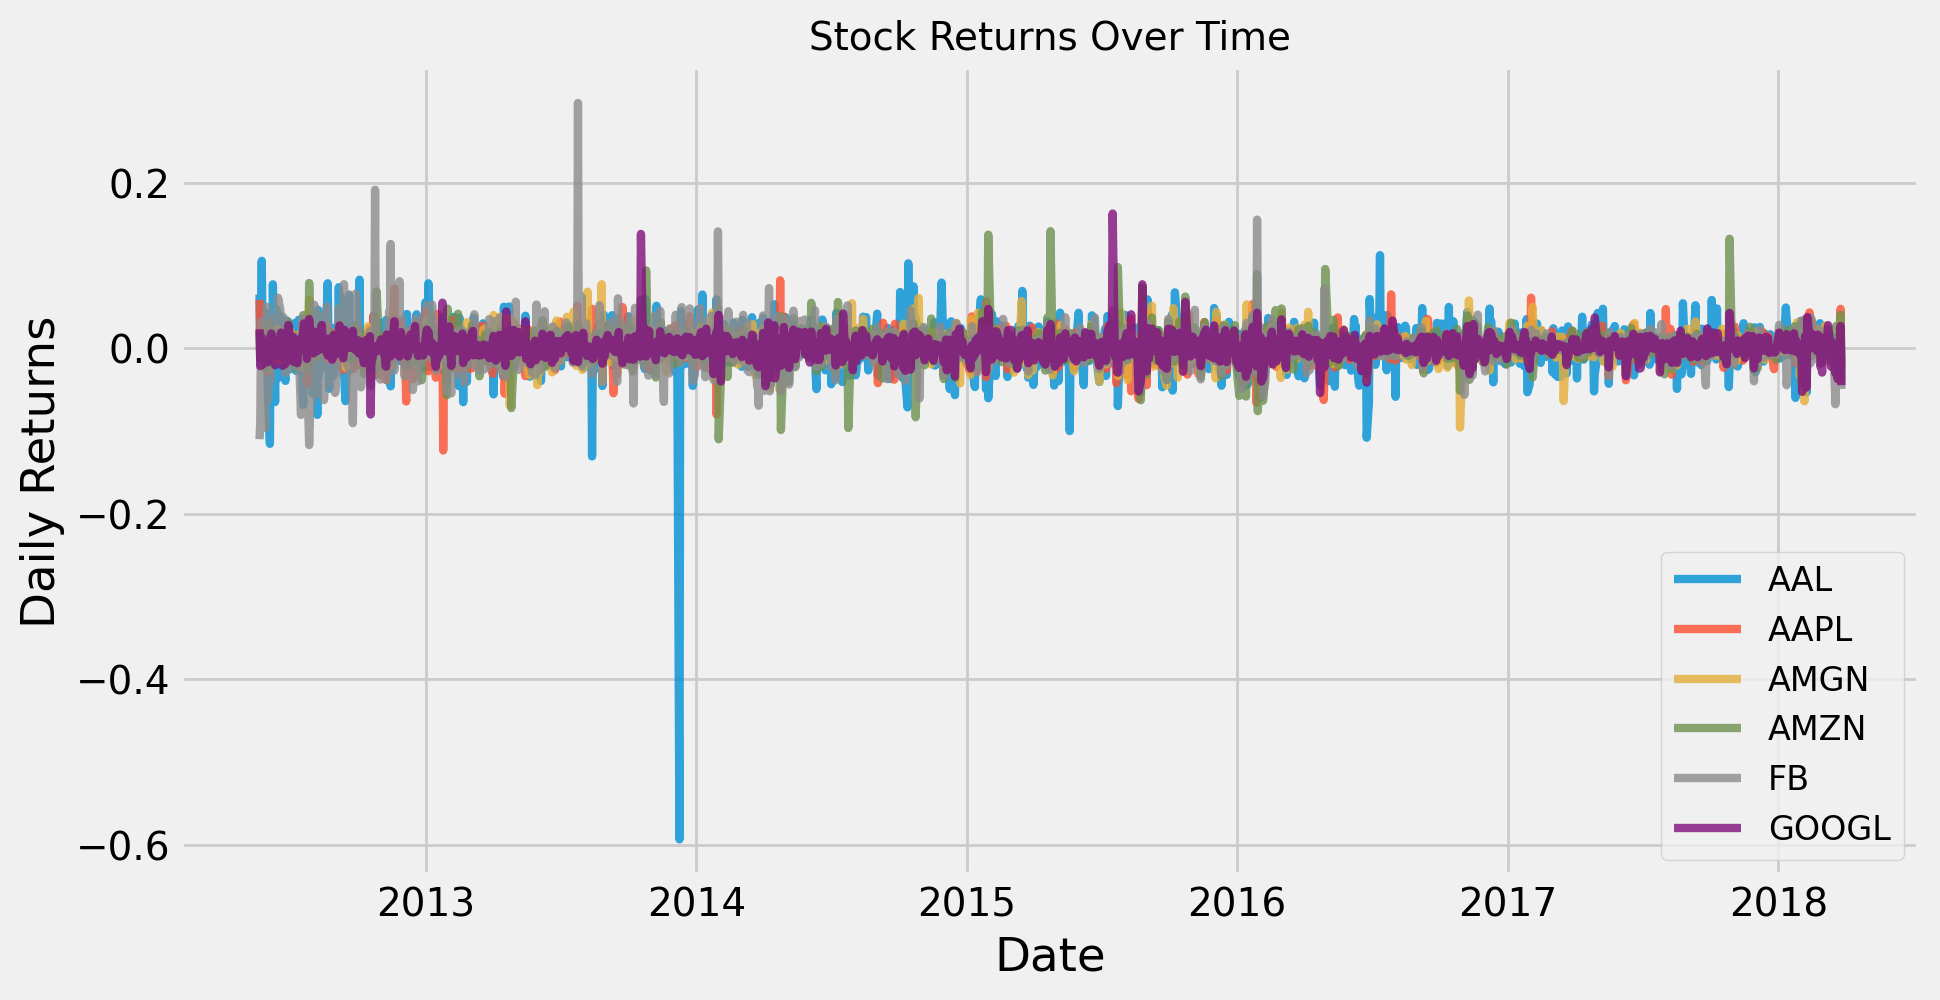

In [14]:
plotReturns(stock_table)

In [15]:
portfolioWriter('myport.in',stock_table)

AttributeError: 'str' object has no attribute 'ndim'

In [16]:
N,expected_ret,sdv_arr,covariance_mat = portfolioReader('./myport.in')

IndexError: list index out of range

In [175]:
#########################################################################
# portfolio Optimization!!!
#########################################################################

In [17]:
def portOpt(prob,SAMPLES = 100):
    # Compute trade-off curve.
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    gamma_vals = np.logspace(-2, 3, num=SAMPLES)
    solutions = []
    for i in range(SAMPLES):
        gamma.value = gamma_vals[i]
        prob.solve(warm_start=False)
        risk_data[i] = cp.sqrt(risk).value
        ret_data[i] = ret.value
        solutions.append(np.copy(w.value))
    return risk_data,ret_data,gamma_vals,solutions

In [ ]:
N,expected_ret,sdv_arr,covariance_mat = portfolioReader('./myport.in')

IndexError: list index out of range

In [19]:
stock_symbols = ['AAPL','AMZN','GOOGL','FB','AAL','AMGN']
#stock_symbols = [str(ii) for ii in range(1,N+1)]

In [21]:
import cvxpy as cp
import numpy as np

# Assuming `N` (number of assets), `expected_ret` (array of returns), and `covariance_mat` (covariance matrix) are already defined
# For example:
# expected_ret = np.array([...])   # Replace with actual expected returns
# covariance_mat = np.array([...])  # Replace with actual covariance matrix

w = cp.Variable(N)  # Portfolio weights (decision variables)
gamma = cp.Parameter(nonneg=True)  # Risk-aversion parameter

# Problem: Expected return (ret) for the portfolio
# Expected return of the portfolio is the dot product of the weights and the individual expected returns
ret = expected_ret @ w  # Expected return: sum(w[i] * expected_ret[i])

# Problem: Risk (variance) of the portfolio
# Portfolio risk is given by: w' * covariance_mat * w
risk = cp.quad_form(w, covariance_mat)  # Quadratic form for portfolio variance

# Problem: Constraints for long-only positions (weights >= 0)
constraints = [w >= 0, cp.sum(w) == 1]  # Weights must be non-negative and sum to 1

# Objective: Maximize expected return minus risk (scaled by risk aversion parameter)
objective = cp.Maximize(ret - gamma * risk)

# Create the optimization problem
prob = cp.Problem(objective, constraints)

# Solve the optimization problem
prob.solve()

# Output the results
print(f"Optimal portfolio weights: {w.value}")
print(f"Optimal expected return: {ret.value}")
print(f"Optimal risk: {risk.value}")


NameError: name 'N' is not defined

In [22]:
prob.solve(warm_start=False)
ret.value

NameError: name 'prob' is not defined

In [23]:
#######################
# Long holds only!!!!
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
ret =
# Problem:risk
# risk is the risk cov matrix for the portfolio, how would you calculate that?
risk = 0
# Problem:constraints_long_hold
# write the constraints for long only holds
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
constraints = [ , ]
objective = cp.Maximize(ret)
prob = cp.Problem(objective,constraints)

SyntaxError: invalid syntax (2571660328.py, line 9)

In [ ]:
prob.solve(warm_start=False)
ret.value

In [258]:
#######################
# Long holds + risk
#######################
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
ret =
# Problem:risk
# risk is the risk cov matrix for the portfolio, how would you calculate that?
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
risk =
# Problem:constraints_long_hold
# write the constraints for long only holds
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
constraints = [ , ]
# Problem:objective_1
# write the constraints for long only holds
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
objective = cp.Maximize( )
prob = cp.Problem(objective,constraints)

In [259]:
risk_data,ret_data,gamma_vals,solutions = portOpt(prob)

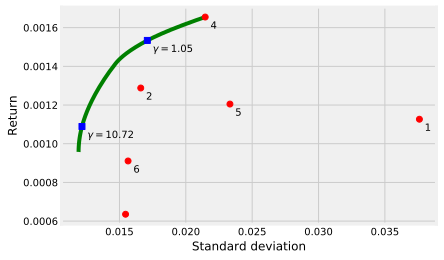

In [260]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [40, 60]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+0.0004, ret_data[marker]-0.00006))
for i in range(N):
    plt.plot(cp.sqrt(covariance_mat[i,i]).value, expected_ret[i], 'ro')
    ax.annotate(stock_symbols[i], xy=(np.sqrt(covariance_mat[i,i])+0.0004, expected_ret[i]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

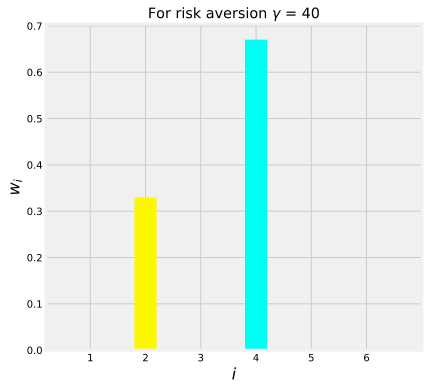

[-1.60235837e-23  3.29653920e-01  3.69338005e-23  6.70346080e-01
  2.57653523e-23  7.88650046e-23]


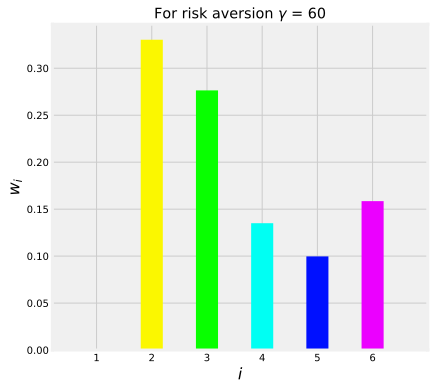

[1.86412596e-23 3.30309954e-01 2.76436061e-01 1.35040863e-01
 9.96597968e-02 1.58553326e-01]


In [261]:
for marker in markers_on:
    colors = ['b', 'g', 'r']
    plt.figure(figsize=(6,6))
    plt.title('For risk aversion $\gamma$ = %.0f' % marker)
    newList = solutions[marker]+[0]
    plt.bar(np.arange(1,N+1), newList, width = 0.4, \
            tick_label=stock_symbols,
            color=[plt.cm.get_cmap('hsv', N+1)(ii) for ii in range(0,N+1)])
    plt.ylabel(r"$w_i$", fontsize=16)
    plt.xlabel(r"$i$", fontsize=16)
    plt.xlim([0.2, 2])
    plt.xticks(np.arange(1,N+2))
    plt.show()
    print(solutions[marker])

In [262]:
#######################
# Maximum leverage constraints
# if you loose in everything, how much 
# will you have to pay?
#######################
w = cp.Variable(N)
Lmax =  cp.Parameter(nonneg=True)
gamma = cp.Parameter(nonneg=True)
# Problem:ret
# ret is the expected return for the portfolio, how would you calculate that?
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
ret =
# Problem:risk
# risk is the cov matrix for the portfolio, how would you calculate that?
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
risk =
# Problem:constraints_maximum_leverage
# write the constraints for long only holds
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
constraints = [,]
# Problem:objective_1
# write the constraints for long only holds
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
objective = cp.Maximize( )
prob = cp.Problem(objective,constraints)

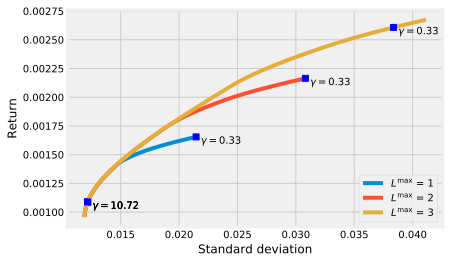

In [268]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [30, 60]
fig = plt.figure()
ax = fig.add_subplot(111)
for Lmax in [1,2,3]:
    # Problem:constraints_maximum_leverage
    constraints = [sum(w) == 1, cp.norm(w, 1) <= Lmax]
    prob = cp.Problem(objective,constraints)
    risk_data,ret_data,gamma_vals,solutions = portOpt(prob)
    plt.plot(risk_data, ret_data, label=r"$L^{\max}$ = %d" % Lmax)
    for marker in markers_on:
        plt.plot(risk_data[marker], ret_data[marker], 'bs')
        ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+0.0004, ret_data[marker]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

In [315]:
#########################################################################
# Optimization with transaction costs
#########################################################################

In [4]:
X = [1/N] * N
A = [0.01]*N
B = [0.01]*N

NameError: name 'N' is not defined

In [478]:
x = np.asarray(X)
a = np.asarray(A)
b = np.asarray(B)
LU = 1
d = 0.000000001

In [490]:
w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
# Problem:risk_costs
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
risk = 
# Problem:ret_costs
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
ret = 
# Problem:constraints_costs
# CENSORED!!CENSORED!!CENSORED!!CENSORED!!
constraints = [, , ]
objective = cp.Maximize(ret-gamma*risk)
problem = cp.Problem(objective, constraints)


cvxpy



In [ ]:
SAMPLES = 10
upper_risk_data = np.zeros(SAMPLES)
upper_ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
solutions = []
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    problem.solve()
    upper_risk_data[i] = cp.sqrt(risk).value
    upper_ret_data[i] = ret.value
    solutions.append(np.copy(w.value))

In [ ]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [2, 9]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(upper_risk_data, upper_ret_data, 'g-')
for marker in markers_on:
    plt.plot(upper_risk_data[marker], upper_ret_data[marker], 'bs')
    ax.annotate("$\gamma = %.2f$" % gamma_vals[marker], xy=(upper_risk_data[marker]+0.0004, upper_ret_data[marker]-0.00006))
for i in range(N):
    plt.plot(cp.sqrt(covariance_mat[i,i]).value, expected_ret[i], 'ro')
    ax.annotate(stock_symbols[i], xy=(np.sqrt(covariance_mat[i,i])+0.0004, expected_ret[i]-0.00006))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
###########################
# Lower bound
###########################
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
Max_Iterations = 50
for i in range(SAMPLES):
    w = cp.Variable(N)
    gamma = cp.Parameter(nonneg=True)
    # Problem:risk_costs
    # CENSORED!!CENSORED!!CENSORED!!CENSORED!!
    risk =
    # Problem:ret_costs
    # CENSORED!!CENSORED!!CENSORED!!CENSORED!!
    ret =
    # Problem:constraints_costs
    # CENSORED!!CENSORED!!CENSORED!!CENSORED!!
    constraints = 
    objective = cp.Maximize(ret-gamma*risk)
    problem = cp.Problem(objective, constraints)
    gamma.value = gamma_vals[i]
    problem.solve(warm_start=False)
    w_prev = np.copy(w.value)
    Keep_Going = True
    k = 0
    while Keep_Going == True and k <= Max_Iterations:
        k += 1
        # Problem:constraints_costs_lower
        # CENSORED!!CENSORED!!CENSORED!!CENSORED!!
        constraints =
        objective = cp.Maximize()
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, use_indirect=True, verbose=False)
        Keep_Going = (np.linalg.norm(w.value-w_prev,2) > d)
        w_prev=np.array(w.value, copy=True)
        risk_data[i] = cp.sqrt(risk).value
        ret_data[i] = ret.value
    if k > Max_Iterations:
        risk_data[i] = 0
        ret_data[i] = 0

In [131]:
# Plot long only trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [5,8]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data[5:9], ret_data[5:9], 'y-')
plt.plot(upper_risk_data[5:9], upper_ret_data[5:9], 'g--')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
upper_risk_data[5:9] - risk_data[5:9]